# GNEMS scratchpad

## Imports and Constants

In [2]:
import torch
import numpy as np
import time
from PIL import Image
import skimage.segmentation
import skimage.color
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import evaluate
import pandas as pd
import json
import maxflow
import pickle
import torch.autograd.profiler as profiler
import glob
import csv
import gc
from evaluate import smart_jaccard
from sklearn.metrics import v_measure_score
import torchvision
from sklearn.cluster import KMeans
import sklearn

# Find fastest device available
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

if device == "mps":
    from torch import mps
    backend = mps
elif device == "cuda":
    from torch import cuda
    backend = cuda


## Algorithm

In [63]:
def get_DINO_embeddings(img):
    input_size = img.shape[-2:]
    input_size = torch.tensor(input_size)
    dino_size = tuple((torch.ceil(input_size[0] / 14) * 14, torch.ceil(input_size[1] / 14) * 14))
    input_size = tuple(input_size)
    dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
    dinov2.to(device)
    dinov2.eval()
    with torch.no_grad():
        scale_size = max(dino_size)
        crop_size = min(dino_size)
        image_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(int(scale_size)),
            torchvision.transforms.CenterCrop(int(crop_size)),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
        img = image_transform(img)
        img = img[:3].to(device)
        embeddings = dinov2.forward_features(img)["x_norm_patchtokens"].squeeze(0)
    dino_size = (int(dino_size[0]), int(dino_size[1]))
    return embeddings, dino_size


def find_nearest_compatible_size(numbers, target=14):
    remainders = numbers % target
    shape = numbers + (target - remainders)
    return shape

def epoch_schedule(x_, max_epochs=40, min_epochs=10, n_iter=4):
    x = x_
    if x == 0:
        return max_epochs
    v = ((5*n_iter)/x) + min_epochs
    v = min(round(v), max_epochs)
    return v

class TileDS(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]
    
def tile(image, d):
    assert image.shape[0] % d == 0 or image.shape[1] % d == 0 # Image dimensions must be divisible by d
    tile_width = (image.shape[0] // d)
    tile_height = (image.shape[1] // d)
    image_tensor = torch.tensor(image, dtype=torch.float32)
    if len(image_tensor.shape) < 3:
        image_tensor = image_tensor.unsqueeze(2)
    tiles = image_tensor.unfold(0, tile_width, tile_height).unfold(1, tile_width, tile_height)
    tiles = tiles.permute(0, 1, 3, 4, 2)
    tiles = tiles.reshape(tiles.shape[0] * tiles.shape[1], tile_width, tile_height, tiles.shape[4])
    return tiles

def initial_labels(image, d=None, n_segments=None, method="slic", compactness=10, sigma=1):
    if method == "slic":
        input_is_embeddings = True
        if image.shape[1] == 3:
            input_is_embeddings = False
        if input_is_embeddings:
            pca = sklearn.decomposition.KernelPCA(n_components=3, kernel="poly")
            im = image.cpu().numpy()
            im = pca.fit_transform(im)
            im = im.reshape(d, d, -1)
        else:
            im = image.squeeze(0).permute(1,2,0).cpu().numpy()
        print(im.shape)
        im -= im.min()
        im /= im.max()
        im *= 255
        seg = skimage.segmentation.slic(im,
                                        n_segments=n_segments, compactness=compactness, sigma=sigma)
        
        seg = torch.tensor(seg)
        print(seg.shape)
        if not input_is_embeddings:
            seg = torch.nn.functional.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(d,d), mode="nearest")
            seg = seg.squeeze().squeeze().long()
        seg = seg.flatten()
        return seg
    if method == "kmeans":
        # print("input shape:", image.shape)
        # points = image.squeeze(0).permute(1,2,0)
        # print("points shape:", points.shape)
        # points = points.reshape(points.shape[0] * points.shape[1], points.shape[2]).cpu().numpy()
        # print("points shape:", points.shape)
        # kmeans = KMeans(n_clusters=n_segments).fit(points)
        # labels = torch.tensor(kmeans.labels_)
        # print("labels shape:", labels.shape)
        # plt.imshow(labels.reshape(37, 37))
        # plt.show()
        embeddings = image.reshape(d,d,-1)[:,:,:].cpu().numpy()
        kmeans = KMeans(n_clusters=10, random_state=0).fit(embeddings.reshape(-1,384))
        labels = kmeans.labels_.reshape(d*d)
        labels = torch.tensor(labels)
        return labels
    elif method == "random":
        labels = torch.randint(n_segments, (d * d,))
        labels = torch.nn.functional.one_hot(labels, n_segments).float()
        return labels

def graph_cut(probabilities, d, k, lambda_):
    lambda_ = lambda_
    # avoid division by zero
    probabilities[probabilities == 0] = 1e-10
    unary = -1 * np.log(probabilities.reshape(d, d, k))
    pairwise = (1 - np.eye(k)) * lambda_
    # result = gco.cut_grid_graph_simple(unary, pairwise)
    result = maxflow.aexpansion_grid(unary.astype(np.double), pairwise.astype(np.double))
    result = result.reshape(d * d)
    return result

def edge_align(pixelwise_predictions_, slic_segmentation_):
    start = time.time()
    pixelwise_predictions = pixelwise_predictions_.to(device) # (512, 512, 10)
    slic_segmentation = slic_segmentation_.to(device)
    slic_segment_indices = torch.unique(slic_segmentation).to(device)

    segmentation_shape = slic_segmentation.shape
    slic_segmentation = torch.flatten(slic_segmentation)
    segment_maps = (slic_segmentation.unsqueeze(0) == slic_segment_indices.unsqueeze(1)).reshape(len(slic_segment_indices), segmentation_shape[0], segmentation_shape[1]) # (916, 512, 512)

    batch_size = 128  # Adjust the batch size as needed
    num_batches = segment_maps.shape[0] // batch_size
    if segment_maps.shape[0] % batch_size != 0:
        num_batches += 1

    averages = []
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, segment_maps.shape[0])
        
        # Perform element-wise multiplication for the current batch
        batch_product = pixelwise_predictions.unsqueeze(0) * segment_maps[start_idx:end_idx].unsqueeze(-1)
        
        # Reshape the batch product to (512^2, 10)
        reshaped_product = batch_product.reshape(batch_product.shape[0], -1, pixelwise_predictions.shape[-1])
        
        # Calculate the average of non-zero elements along axis 0
        nonzero_count = reshaped_product.sum(dim=-1).count_nonzero(dim=1)
        nonzero_average = reshaped_product.sum(dim=1) / nonzero_count.unsqueeze(-1)

        # Append the average to the list
        averages.append(nonzero_average)

    averages = torch.cat(averages, dim=0)
    segment_predictions = averages.argmax(dim=1) # (916)

    # Create a broadcasted mask using broadcasting
    mask = slic_segmentation.unsqueeze(-1) == slic_segment_indices.unsqueeze(0)

    # Perform element-wise multiplication and sum along the second dimension
    integer_predictions = (mask.float() * segment_predictions.unsqueeze(0)).sum(dim=1)

    integer_predictions = integer_predictions.reshape(segmentation_shape)
    
    return integer_predictions

class GNEMNet(torch.nn.Module):
    def __init__(self, k=10, n_filters=16, dropout=0.2):
        super(GNEMNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(384, n_filters, 3, padding=1)
        self.BN1 = torch.nn.BatchNorm2d(n_filters)
        self.conv2 = torch.nn.Conv2d(n_filters, n_filters, 3, padding=1)
        self.BN2 = torch.nn.BatchNorm2d(n_filters)
        self.conv3 = torch.nn.Conv2d(n_filters, k, 3, padding=1)
        self.dropout = torch.nn.Dropout2d(p=dropout)
        self.train_indices = None

    def forward(self, x):
        x = self.conv1(x)
        x = self.BN1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = torch.sigmoid(x)
        return x
    
def diversity_loss_1(distributions):
    log_probs = torch.log(distributions)
    tmp = -distributions * log_probs
    tmp[torch.isnan(tmp)] = 0
    entropy = torch.sum(tmp, dim=0)
    entropy = -1 * entropy.mean()
    return entropy

def diversity_loss_2(distributions):
    k = distributions.shape[1]
    argmaxes = distributions.argmax(dim=1)
    # create onehot version of argmaxes
    onehot = torch.zeros_like(distributions)
    onehot.scatter_(1, argmaxes.unsqueeze(1), 1)

    counts = onehot.sum(dim=0)
    # create probabilities from counts
    probs = counts / counts.sum()
    tmp = -probs * torch.log(probs)
    tmp[torch.isnan(tmp)] = 0
    entropy = torch.sum(tmp)
    return -1 * entropy

class GNEMS_Segmentor:
    def __init__(self, d=16, n_filters=16, dropout=0.2,
                lambda_=0.3, size=(512, 512), lr=0.001,
                iterations=100, subset_size=0.5,
                prediction_stride=1, slic_segments=100,
                sigma=3, compactness=10, seed=0, k=10, epochs=10,
                initialization_method="slic", epoch_schedule=None,
                max_epochs=40, min_epochs=10,
                diversity_loss_1_weight=0.0, diversity_loss_2_weight=0.0):
        self.d = int(np.ceil(size[0] / 14))
        self.n_filters = n_filters
        self.dropout = dropout
        self.lambda_ = lambda_
        self.size = size
        self.tile_size = (14, 14)
        self.lr = lr
        self.iterations = iterations
        self.subset_size = subset_size
        self.prediction_stride = prediction_stride
        self.seed = seed
        self.net = None
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.slic_segments = slic_segments
        self.sigma = sigma
        self.compactness = compactness
        self.k = k
        self.initial_labels = None
        self.epochs = epochs
        self.initialization_method = initialization_method
        self.epoch_schedule = epoch_schedule
        self.max_epochs = max_epochs
        self.min_epochs = min_epochs
        self.diversity_loss_1_weight = diversity_loss_1_weight
        self.diversity_loss_2_weight = diversity_loss_2_weight
        self.intermediate_cross_entropies = []
        self.intermediate_diversities = []
        self.initial_segmentation = None
        self.dino_embeddings = None

    def fit(self, image):
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.image = image
        self.image_size = image.shape[:2]
        self.image_tensor = torch.tensor(self.image, dtype=torch.float32).to(device).permute(2, 0, 1).unsqueeze(0)

        # Get DINO embeddings
        self.dino_embeddings_, self.dino_shape = get_DINO_embeddings(self.image_tensor)
        self.dino_embeddings = self.dino_embeddings_

        # standardize image to [-1,1]
        cur_min = self.image_tensor.min()
        cur_max = self.image_tensor.max()
        self.image_tensor = (2 * (self.image_tensor - cur_min)/(cur_max - cur_min)) - 1
        x_grid, y_grid = torch.meshgrid(torch.linspace(-1, 1, self.dino_shape[0] // 14), torch.linspace(-1, 1, self.dino_shape[1] // 14))
        coord_grid = torch.stack((x_grid, y_grid), dim=0).unsqueeze(0).to(device) / 2

        # concatenate image and coordinate grid
        # self.dino_embeddings_with_spatial = torch.cat((self.dino_embeddings, coord_grid), dim=1)

        self.k_tensor = torch.tensor(self.k, dtype=torch.int).to(device)

        # Generate tiles and initial labels
        X = self.dino_embeddings.permute(1,0).reshape(384, self.d, self.d).unsqueeze(0)
        # y_initial = initial_labels(self.dino_embeddings, method="kmeans", n_segments=self.k, d=self.d)
        y_initial = initial_labels(self.dino_embeddings, method="slic", n_segments=self.k, d=self.d, compactness=self.compactness, sigma=self.sigma)
        y_initial = y_initial.type(torch.long).to(device)
        self.initial_labels = y_initial

        # Initialize CNN
        self.net = GNEMNet(n_filters=self.n_filters, dropout=self.dropout, k=self.k).to(device)
        self.net.train()

        # Initialize optimizer and loss function
        y_intermediate = y_initial.clone().detach()
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        # Train CNN
        for iteration in range(self.iterations):
            y_intermediate_subset = y_intermediate

            n_epochs = self.epochs
            if self.epoch_schedule is not None:
                n_epochs = self.epoch_schedule(iteration, max_epochs=self.max_epochs, min_epochs=self.min_epochs, n_iter=self.iterations)
                # print(f"Using {n_epochs} epochs for iteration {iteration}")
            for epoch in range(n_epochs):
                # Perform network step
                labels = y_intermediate_subset.unsqueeze(0)
                optimizer.zero_grad()
                outputs = self.net(X).reshape(1, self.k, -1)
                ce = criterion(outputs, labels)
                self.losses.append(ce.item())
                ce.backward()
                optimizer.step()
                
            outputs = self.net(X).reshape(1, self.k, -1)

            # Calculate probabilities for each tile
            probabilities = outputs.detach().squeeze(1).squeeze(0).permute(1,0).cpu().numpy()
            # print(probabilities.shape)

            # Skip graph step on last iteration
            if iteration != self.iterations - 1:
                # Perform graph step
                partition = torch.tensor(graph_cut(probabilities, self.d, self.k, self.lambda_), dtype=torch.int64)
                partition = torch.nn.functional.one_hot(partition, self.k)
                self.intermediate_partitions.append(partition)
                

                # Update pseudo-labels
                y_intermediate = torch.Tensor(partition).to(device).argmax(dim=1).type(torch.long)
        
    def predict(self, output_cpu=False):
        pass
        # self.net.eval()
        # self.net.use_subset = False
        # self.net.unfold_stride = 1
        # self.net.make_patches = True
        # interpolated = self.net(self.image_tensor).detach().squeeze(-1).squeeze(-1).squeeze(0).permute(1, 2, 0).argmax(2)
        # return interpolated

## Testbench

Using cache found in /Users/isaac/.cache/torch/hub/facebookresearch_dinov2_main
/Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(37, 37, 3)
torch.Size([37, 37])


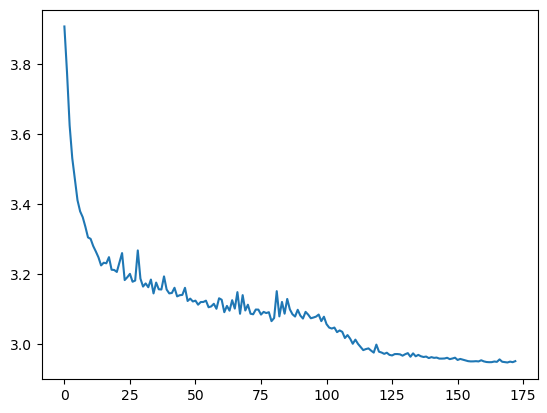

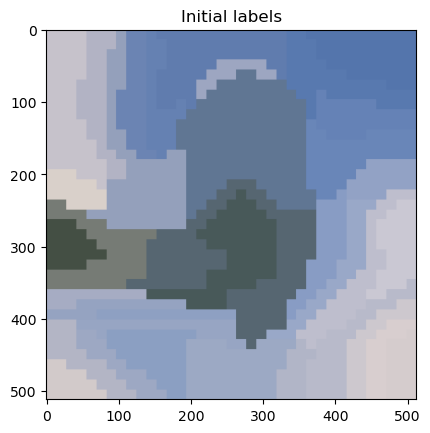

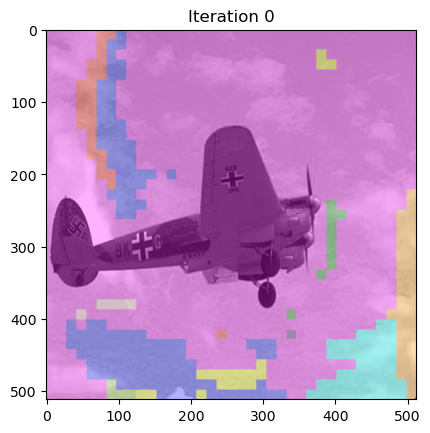

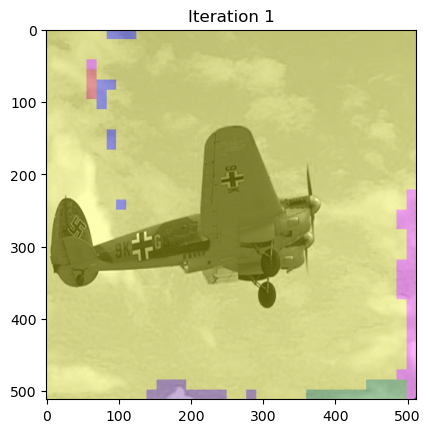

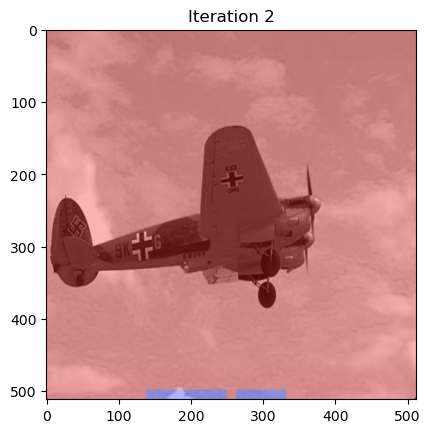

In [64]:
id = "3063"
image = np.array(Image.open(f"datasets/BSDS500/BSDS500/data/images/test/{id}.jpg").resize((512, 512)))[:,:,:3]
k = 50
lambda_ = 0
lr = 0.01
subset_size = 0.5
max_epochs = 100
min_epochs = 12

segmentor = GNEMS_Segmentor(iterations=4, k=k, lambda_=lambda_,
                            subset_size=subset_size, lr=lr, n_filters=32,
                            epoch_schedule=epoch_schedule, max_epochs=max_epochs, min_epochs=min_epochs, compactness=0.01)
segmentor.fit(image)

plt.plot(segmentor.losses)
plt.show()

initial_labels_ = segmentor.initial_labels.reshape(37,37)
initial_labels_ = torch.nn.functional.interpolate(initial_labels_.unsqueeze(0).unsqueeze(0).float(), size=(512,512), mode="nearest").squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(skimage.color.label2rgb(initial_labels_, image, kind="avg"))
plt.title("Initial labels")
plt.show()

for i in range(len(segmentor.intermediate_partitions)):
    seg = segmentor.intermediate_partitions[i].reshape(37,37,k).cpu().permute(2,0,1).unsqueeze(0).float()
    seg = torch.nn.functional.interpolate(seg, size=(512,512), mode="nearest").squeeze(0).permute(1,2,0).argmax(2).cpu().numpy()
    plt.imshow(skimage.color.label2rgb(seg, image))
    plt.title(f"Iteration {i}")
    plt.show()

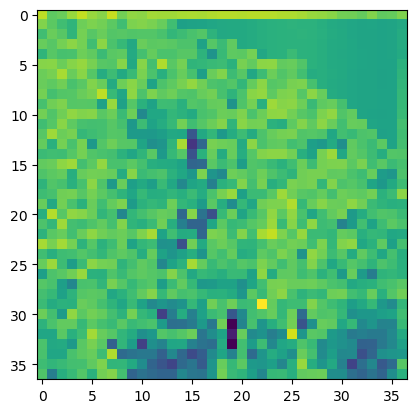

In [48]:
plt.imshow(segmentor.dino_embeddings.reshape(37,37,384).cpu().numpy()[:,:,5])

In [47]:
def score(id, segmentation):
    gt_paths = glob.glob(f"datasets/BSDS500/gt/{id}-*.csv")
    gts = [np.genfromtxt(path, delimiter=',') for path in gt_paths]
    resized = torch.tensor(segmentation)
    resized = torch.nn.functional.interpolate(resized.unsqueeze(0).unsqueeze(0).float(), size=gts[0].shape, mode="nearest").squeeze(0).squeeze(0).cpu().numpy()
    scores = []
    for gt in gts:
        scores.append(v_measure_score(gt.flatten(), resized.flatten()))
    return np.mean(scores)

seg = segmentor.intermediate_partitions[6].reshape(37,37,k).cpu().argmax(2).float()
print(seg.shape)
print("v_measure:", score(id, seg))

IndexError: list index out of range

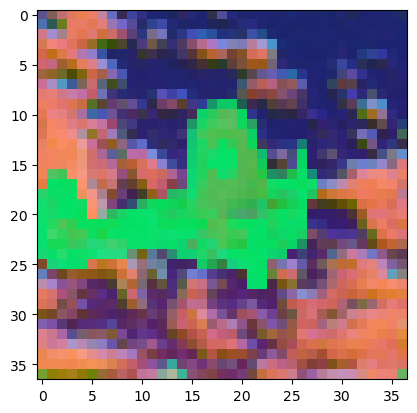

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [6 6 6 ... 1 1 1]
 [6 6 6 ... 1 1 1]
 [6 6 6 ... 1 1 1]]


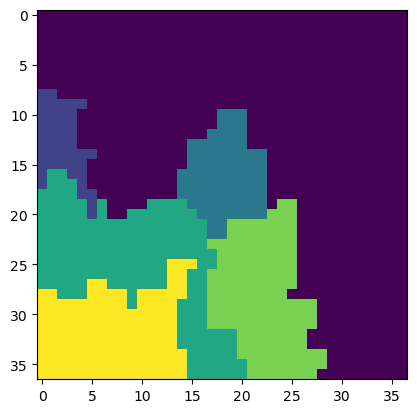

In [54]:
# import libraries and perform PCA
from sklearn.decomposition import PCA, KernelPCA
# import tsne
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# load data
data = segmentor.dino_embeddings.cpu().numpy()

# standardize data
# scaler = StandardScaler()
# scaler.fit(data)
# data = scaler.transform(data)

# perform PCA
pca = KernelPCA(n_components=3, kernel="poly")

# fit PCA
pca.fit(data)

# transform data
data = pca.transform(data)

data = data.reshape(37,37,-1)
data -= np.min(data)
data /= np.max(data)
data *= 255
data = data.astype(np.uint8)
plt.imshow(data[:,:,:3])
plt.show()

labels = skimage.segmentation.slic(data, n_segments=20, compactness=0.1)
print(labels)
plt.imshow(labels)

In [98]:
tsne = TSNE(n_components=3, perplexity=10, n_iter=1000, verbose=1, init="pca")
data = tsne.fit_transform(data.reshape(-1, 3))
data = data.reshape(37,37,-1)
data -= np.min(data)
data /= np.max(data)
data *= 255
data = data.astype(np.uint8)
plt.imshow(data)
plt.show()


/Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 175232 samples in 0.060s...
[t-SNE] Computed neighbors for 175232 samples in 1.286s...
[t-SNE] Computed conditional probabilities for sample 1000 / 175232
[t-SNE] Computed conditional probabilities for sample 2000 / 175232
[t-SNE] Computed conditional probabilities for sample 3000 / 175232
[t-SNE] Computed conditional probabilities for sample 4000 / 175232
[t-SNE] Computed conditional probabilities for sample 5000 / 175232
[t-SNE] Computed conditional probabilities for sample 6000 / 175232
[t-SNE] Computed conditional probabilities for sample 7000 / 175232
[t-SNE] Computed conditional probabilities for sample 8000 / 175232
[t-SNE] Computed conditional probabilities for sample 9000 / 175232
[t-SNE] Computed conditional probabilities for sample 10000 / 175232
[t-SNE] Computed conditional probabilities for sample 11000 / 175232
[t-SNE] Computed conditional probabilities for sample 12000 / 175232
[t-SNE] Computed conditional probabi

/Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


KeyboardInterrupt: 